<a href="https://colab.research.google.com/github/BrotherKim/KAIST_CODE/blob/master/SEP531/term/2_KoBERT_labeled_data_finetune_small.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#실행 환경#

- Python >= 3.6
- PyTorch >= 1.70
- Transformers = 3.0.2
- Colab
- batch size = 64 (convertable)
- epochs = 10 (convertable)

In [ ]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3.0.2
!pip install torch

#KoBERT 다운로드#

In [ ]:
#깃허브에서 KoBERT 파일 로드
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-n4u4mwjv
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-n4u4mwjv


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

In [ ]:
#kobert
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [ ]:
#GPU 사용
device = torch.device("cuda:0")

In [ ]:
#BERT 모델, Vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model()

using cached model
using cached model


#데이터셋 전처리#

In [ ]:
#구글드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 터미널 커맨드를 문자열로 반환해주는 함수 작성

import subprocess

def GetShellCmdStdOut(command):
  cmd = ['sh', '-c', command]
  fd_popen = subprocess.Popen(cmd, stdout=subprocess.PIPE).stdout 
  data = fd_popen.read().strip() 
  fd_popen.close()

  retval = data.decode('utf-8') 
  return retval

In [ ]:
ROOT_DIR = '/content/drive/MyDrive/KAIST/SEP531/kor_ks_labeled'
TRAIN_DIR = '%s/train' % ROOT_DIR
VALID_DIR = '%s/valid' % ROOT_DIR

In [ ]:
%pushd $TRAIN_DIR
tl = GetShellCmdStdOut('find | grep json.answer').split('\n')
train_json_list = [x.replace('./', '') for x in tl]
%popd

/content/drive/MyDrive/KAIST/SEP531/kor_ks_labeled/train
/content
popd -> /content


In [ ]:
%pushd $VALID_DIR
vl = GetShellCmdStdOut('find | grep json.answer').split('\n')
valid_json_list = [x.replace('./', '') for x in vl]
%popd

/content/drive/MyDrive/KAIST/SEP531/kor_ks_labeled/valid
/content
popd -> /content


In [ ]:
print('%d %d\n' % (len(train_json_list), len(valid_json_list)))

109 156



In [ ]:
import csv

dic = {0:'공포', 1:'놀람', 2:'분노', 3:'슬픔', 4:'중립', 5:'행복', 6:'혐오'}

std_data_list = []
dia_data_list = []
for tf in train_json_list[0:8]:
  with open('%s/%s' % (TRAIN_DIR, tf), newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter='\t')
    for row in spamreader:
      std_data = []
      std_data.append(row[0])
      std_data.append(row[2])
      std_data_list.append(std_data)

      dia_data = []
      dia_data.append(row[1])
      dia_data.append(row[2])
      dia_data_list.append(dia_data)
      #print('%s(%s) %s\n' % (dic.get(int(row[2])), row[2], row[0]))

In [ ]:
len(std_data_list)

2186

#데이터셋 쪼개기#

In [ ]:
data_list = std_data_list

In [ ]:
#train & test 데이터로 나누기
from sklearn.model_selection import train_test_split
                                                         
dataset_train, dataset_test = train_test_split(data_list, test_size=0.25, random_state=0)

In [ ]:
print(len(dataset_train))
print(len(dataset_test))

1639
547


#KoBERT 입력 데이터로 변환#

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [ ]:
# Setting parameters
max_len = 64
batch_size = 64 # origin : 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [ ]:
#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

using cached model


In [ ]:
# 첫번째는 패딩된 시퀀스, 두번째는 길이와 티입, 세번째는 어텐션 마스크 시퀀스
data_train[0]

(array([   2, 2145,  517,  463, 1138, 6559, 4700, 4155, 5655, 2145,  517,
         463, 3223, 1316, 7728, 6903,    3,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1], dtype=int32),
 array(17, dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=int32),
 4)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

#KoBERT 학습모델 만들기#

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=7,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:
#BERT 모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
    
train_dataloader

RuntimeError: ignored

#KoBERT 모델 학습시키기#

In [ ]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

In [ ]:
SAVEPOINT_PATH = '/content/drive/MyDrive/KAIST/SEP531/KoBERT_small_std_data.pt'

In [ ]:
torch.save(model.state_dict(), SAVEPOINT_PATH)

#새로운 문장 테스트#

새로운 문장을 테스트 할 때, 입력되는 문장을 KoBERT의 입력 형식으로 바꿔주는 코드를 작성해주어야 한다. 아래 코드를 작성하여 토큰화, 패딩, 텐서를 바꿔주고 예측을 하는 'predict' 함수를 만들어 주었다.

In [ ]:
#GPU 사용
device = torch.device("cuda:0")

In [ ]:
#BERT 모델, Vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model()

using cached model
using cached model


In [ ]:
model1 = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)
model1.load_state_dict(torch.load(SAVEPOINT_PATH))
model1.eval()

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True

In [ ]:
#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
    model1.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model1(token_ids, valid_length, segment_ids)


        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:
                test_eval.append("공포가")
            elif np.argmax(logits) == 1:
                test_eval.append("놀람이")
            elif np.argmax(logits) == 2:
                test_eval.append("분노가")
            elif np.argmax(logits) == 3:
                test_eval.append("슬픔이")
            elif np.argmax(logits) == 4:
                test_eval.append("중립이")
            elif np.argmax(logits) == 5:
                test_eval.append("행복이")
            elif np.argmax(logits) == 6:
                test_eval.append("혐오가")

        print(">> 입력하신 내용에서 " + test_eval[0] + " 느껴집니다.")

using cached model


In [ ]:
#질문 무한반복하기! 0 입력시 종료
end = 1
while end == 1 :
    sentence = input("하고싶은 말을 입력해주세요 : ")
    if sentence == '종료' :
        break
    predict(sentence)
    print("\n")

하고싶은 말을 입력해주세요 : 안녕안녕


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


>> 입력하신 내용에서 행복이 느껴집니다.


하고싶은 말을 입력해주세요 : 좋아좋아
>> 입력하신 내용에서 행복이 느껴집니다.


하고싶은 말을 입력해주세요 : 아니 이건 아니잖아
>> 입력하신 내용에서 놀람이 느껴집니다.




KeyboardInterrupt: ignored

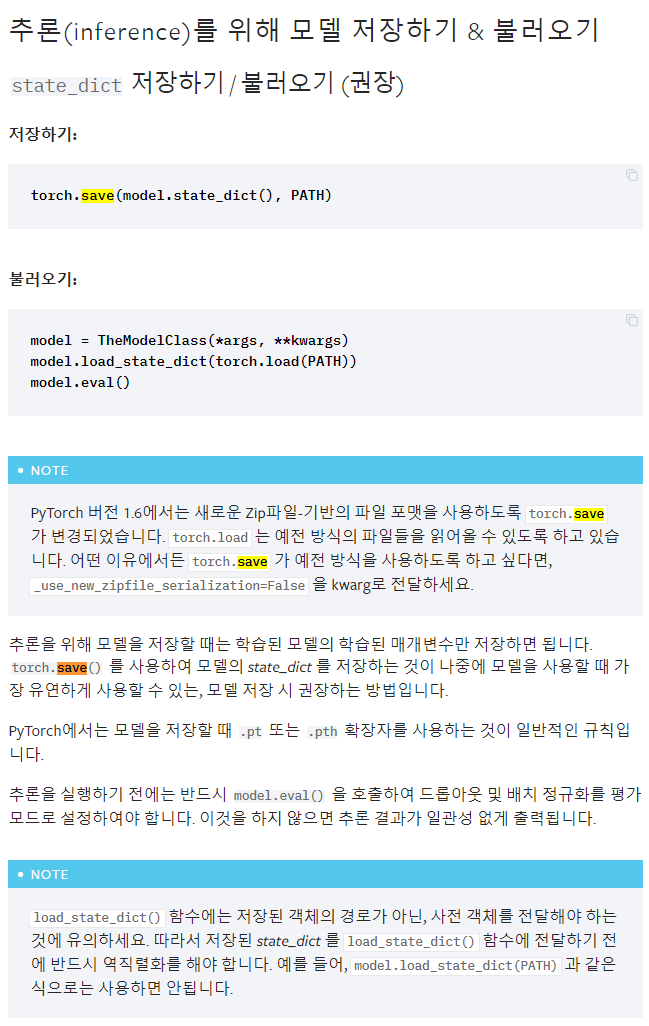